# MALIGNANT COMMENTS CLASSIFICATION


In [114]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno
import pandas_profiling
from scipy import interp
#import scikitplot as skplt
from itertools import cycle
import matplotlib.ticker as plticker

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, regexp_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.sparse import csr_matrix

import timeit, sys
from sklearn import metrics
import tqdm.notebook as tqdm
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import hamming_loss, log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, multilabel_confusion_matrix

In [87]:
#Import Dataset

df_train= pd.read_csv("train.csv")
df_train

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [14]:
# df_test = pd.read_csv('test.csv')
df_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


# Exploratory Data Analysis


In [15]:
print("We have {} Rows and {} Columns in our dataframe".format(df_train.shape[0], df_train.shape[1]))

df_train.head(20)

We have 159571 Rows and 8 Columns in our dataframe


,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


Column Description:



In [16]:
df_train.isna().sum() # checking for missing values

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

Using the isna and sum options together we can confirm that there are no missing values in any of the columns present in our training dataset.



In [17]:
missingno.bar(df_train, figsize = (25,5), color="tab:green")

NameError: name 'missingno' is not defined

In [18]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


Using the info method we are able to confirm the non null count details as well as the datatype information. We have a total of 8 columns out of which 2 columns have object datatype while the remaining 6 columns are of integer datatype.



In [24]:
# checking ratio of data which contains malignant comments and normal or unoffensive comments.
output_labels = df_train.columns[2:]

# counting non-zero rows i.e. Malignant Comments
malignant_comments = len(df_train[df_train[output_labels].any(axis=1)])

# counting rows containing zero i.e. Normal Comments
normal_comments = len(df_train)-malignant_comments

print(f"Total Malignant Comments: {malignant_comments} ({round(malignant_comments*100/len(df_train),2)}%)")
print(f"Total Normal Comments: {normal_comments} ({round(normal_comments*100/len(df_train),2)}%)")

Total Malignant Comments: 16225 (10.17%)
Total Normal Comments: 143346 (89.83%)


In [25]:
# checking the length of comments and storing it into another column 'original_length'
# copying df_train into another object df
df = df_train.copy()
df['original_length'] = df.comment_text.str.len()

# checking the first five and last five rows here
df

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,295
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,99
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,81
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,116


In [26]:
# Data Cleansing

# as the feature 'id' has no relevance w.r.t. model training I am dropping this column
df.drop(columns=['id'],inplace=True)
# converting comment text to lowercase format
df['comment_text'] = df.comment_text.str.lower()
df.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length
0,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0,264
1,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0,112
2,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0,233
3,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0,622
4,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0,67


In [49]:

# Removing and Replacing unwanted characters in the comment_text column

# Replacing '\n' with ' '
df.comment_text = df.comment_text.str.replace('\n',' ')

# Keeping only text with letters a to z, 0 to 9 and words like can't, don't, couldn't etc
df.comment_text = df.comment_text.apply(lambda x: ' '.join(regexp_tokenize(x,"[a-z']+")))

# Removing Stop Words and Punctuations

# Getting the list of stop words of english language as set
stop_words = set(stopwords.words('english'))

# Updating the stop_words set by adding letters from a to z
for ch in range(ord('a'),ord('z')+1):
    stop_words.update(chr(ch))
    
# Updating stop_words further by adding some custom words
custom_words = ("d'aww","mr","hmm","umm","also","maybe","that's","he's","she's","i'll","he'll","she'll","us",
                "ok","there's","hey","heh","hi","oh","bbq","i'm","i've","nt","can't","could","ur","re","ve",
                "rofl","lol","stfu","lmk","ily","yolo","smh","lmfao","nvm","ikr","ofc","omg","ilu")
stop_words.update(custom_words)

# Checking the new list of stop words
print("New list of custom stop words are as follows:\n\n")
print(stop_words)

New list of custom stop words are as follows:


{'any', 'f', 'if', 'than', "d'aww", 'our', 'mustn', 'was', 'did', 'some', 'too', 'lol', 'haven', 'him', 'will', 'l', 'hmm', 'us', 'ok', 'should', 'hadn', 'been', "doesn't", "that'll", 'nor', "wasn't", 'now', 'during', 'll', 'at', "i've", 'being', 'yourself', 'those', 'an', "won't", 'whom', 'off', 'until', 'myself', 'having', 'by', 'y', 'were', 'very', 'here', 'smh', 'are', 'down', "she'll", 'hey', 'lmfao', 'your', 'few', "he'll", 'm', 'most', 'below', 'needn', 'is', 'herself', "hadn't", 'itself', 'not', "you've", 'have', 'shan', 'ilu', 'no', 'could', 're', 'over', 'you', 'mightn', 'again', 'aren', 'weren', 'their', 'into', 'himself', 'above', 'e', 'j', 'ourselves', "weren't", 'a', 'x', 'it', "don't", 'between', 'maybe', 'when', 't', "wouldn't", 'such', 'so', 'u', 'because', 'hers', 'ain', 'who', 'has', 'he', 'the', 'before', 'but', 'while', "mightn't", "should've", "you'll", 'k', 'v', 'about', 'these', 'had', 'me', "didn't", "mustn't", 'h

In [50]:
# Removing stop words
df.comment_text = df.comment_text.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words).strip())

# Removing punctuations
df.comment_text = df.comment_text.str.replace("[^\w\d\s]","")

# Checking any 10 random rows to see the applied changes
df.sample(10)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length
41403,thing long please shorten itshouldn,0,0,0,0,0,0,58
141927,question recent rfa asked improved since last ...,0,0,0,0,0,0,625
3796,sorry spend life wikipedia good luck trying le...,0,0,0,0,0,0,104
22530,sorry late response heres soruce saying mac wa...,0,0,0,0,0,0,196
61820,perhaps explain inoccuous comment pity take br...,0,0,0,0,0,0,266
134817,sir please look behaviour fishing blocks talk,0,0,0,0,0,0,83
97122,help please add final warning tag users talk page,0,0,0,0,0,0,71
42632,think gay well,1,0,0,0,0,0,33
124449,talkback,0,0,0,0,0,0,29
138909,jim dr brett snodgrass research fellow working...,0,0,0,0,0,0,350


In [53]:
# Stemming words
snb_stem = SnowballStemmer('english')
df.comment_text = df.comment_text.apply(lambda x: ' '.join(snb_stem.stem(word) for word in word_tokenize(x)))

# Checking any 10 random rows to see the applied changes
df.sample(10)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length
6331,side notic peopl list articl diner movi peopl ...,0,0,0,0,0,0,234
108777,page delet,0,0,0,0,0,0,33
151736,salsb pseudosci hello end relat chang aetherom...,0,0,0,0,0,0,484
88223,feraldruid king rimjob,0,0,0,0,0,0,34
112136,complet block even respect rule three public p...,0,0,0,0,0,0,1193
61359,eras decid leav one use,0,0,0,0,0,0,59
21360,curious wonder what signific mike hunter air f...,0,0,0,0,0,0,205
145079,barnstar origin barnstar thank concern pashtun...,0,0,0,0,0,0,133
15878,go use drug insignific nobodi eras stalker edit,1,0,0,0,1,0,64
19991,like imag copyvio oi sitush strong doubt work ...,0,0,0,0,0,0,202


In [52]:
from nltk.stem.snowball import SnowballStemmer 

In [54]:
# Checking the length of comment_text after cleaning and storing it in cleaned_length variable
df["cleaned_length"] = df.comment_text.str.len()

# Taking a loot at first 10 rows of data
df.head(10)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length,cleaned_length
0,explan edit made usernam hardcor metallica fan...,0,0,0,0,0,0,264,135
1,match background colour seem stuck thank talk ...,0,0,0,0,0,0,112,57
2,man realli tri edit war guy constant remov rel...,0,0,0,0,0,0,233,112
3,make real suggest improv wonder section statis...,0,0,0,0,0,0,622,310
4,sir hero chanc rememb page,0,0,0,0,0,0,67,26
5,congratul well use tool well talk,0,0,0,0,0,0,65,33
6,cocksuck piss around work,1,1,1,0,1,0,44,25
7,vandal matt shirvington articl revert pleas ban,0,0,0,0,0,0,115,47
8,sorri word nonsens offens anyway intend write ...,0,0,0,0,0,0,472,235
9,align subject contrari dulithgow,0,0,0,0,0,0,70,32


In [55]:
# Now checking the percentage of length cleaned
print(f"Total Original Length        : {df.original_length.sum()}")
print(f"Total Cleaned Length         : {df.cleaned_length.sum()}")
print(f"Percentage of Length Cleaned : {(df.original_length.sum()-df.cleaned_length.sum())*100/df.original_length.sum()}%")

Total Original Length        : 62893130
Total Cleaned Length         : 34297506
Percentage of Length Cleaned : 45.46700728680541%


# Visualization


pandas-profiling is an open source Python module with which we can quickly do an exploratory data analysis with just a few lines of code. It generates interactive reports in web format that can be presented to any person. It also offers report generation for the dataset with lots of features and customizations for the report generated. It generates a report with all the information easily available.

In [60]:
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

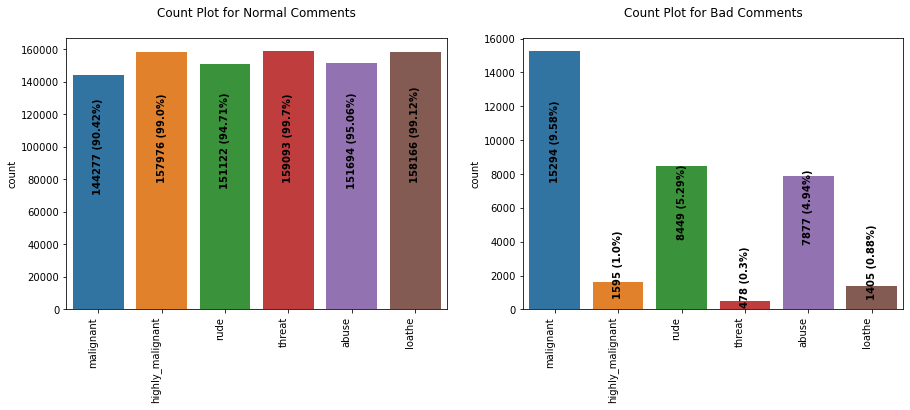

In [61]:
# comparing normal comments and bad comments using count plot

fig, ax = plt.subplots(1,2,figsize=(15,5))

for i in range(2):
    sns.countplot(data=df[output_labels][df[output_labels]==i], ax=ax[i])
    if i == 0:
        ax[i].set_title("Count Plot for Normal Comments\n")
    else:
        ax[i].set_title("Count Plot for Bad Comments\n")
        
    ax[i].set_xticklabels(output_labels, rotation=90, ha="right")
    p=0
    for prop in ax[i].patches:
        count = prop.get_height()
        s = f"{count} ({round(count*100/len(df),2)}%)"
        ax[i].text(p,count/2,s,rotation=90, ha="center", fontweight="bold")
        p += 1

plt.show()

Observation:



Dataset consists of higher number of Normal Comments than Bad or Malignant Comments. Therefore, it is clear that dataset is imbalanced and needs to be handle accordingly.
Most of the bad comments are of type malignant while least number of type threat is present in dataset.
Majority of bad comments are of type malignant, rude and abuse.

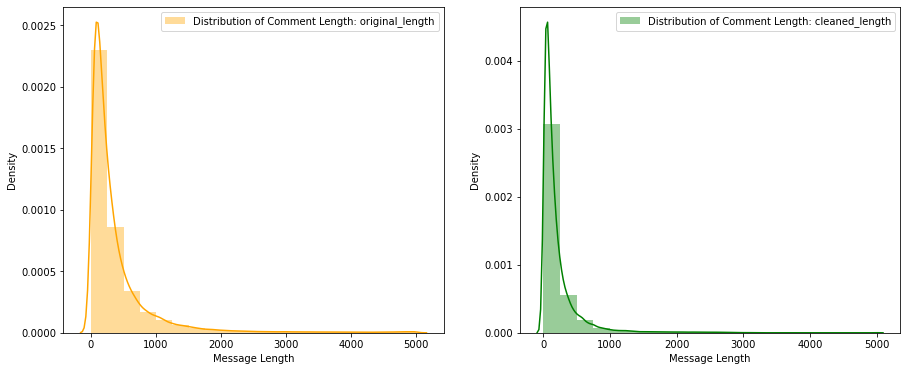

In [63]:
# Comparing the comment text length distribution before cleaning and after cleaning

fig, ax = plt.subplots(1,2,figsize=(15,6))
j=0
colors = ['orange','green']
for i in df.columns[-2:]:
    label_text = f"Distribution of Comment Length: {i}"
    sns.distplot(df[i],ax=ax[j],bins=20,color=colors[j],label=label_text)
    ax[j].set_xlabel("Message Length")
    ax[j].legend()
    j += 1
    
plt.show()

Before cleaning comment_text column most of the comment's length lies between 0 to 1100 while after cleaning it has been reduced between 0 to 900.


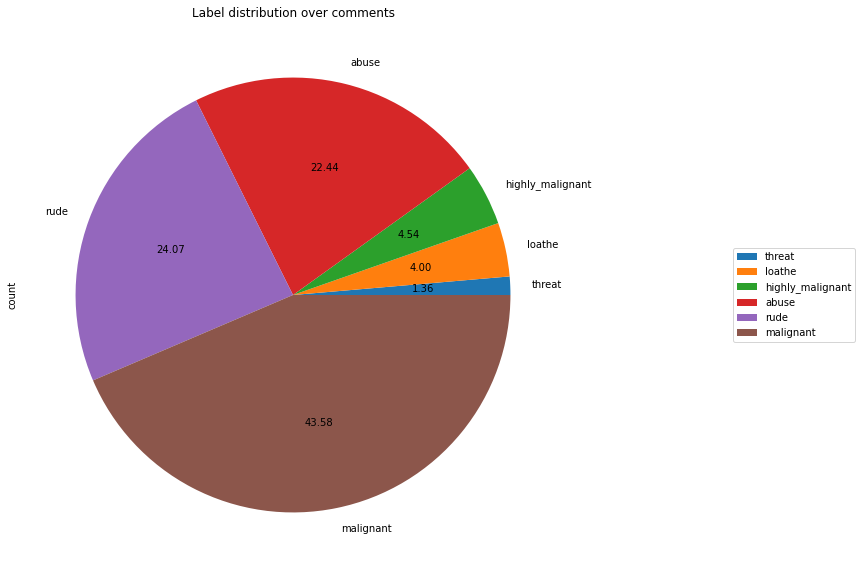

In [64]:
# Visualizing the label distribution of comments using pie chart

comments_labels = ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']
df_distribution = df_train[comments_labels].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.plot.pie(y = 'count', title = 'Label distribution over comments', autopct='%.2f', figsize = (15, 10))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

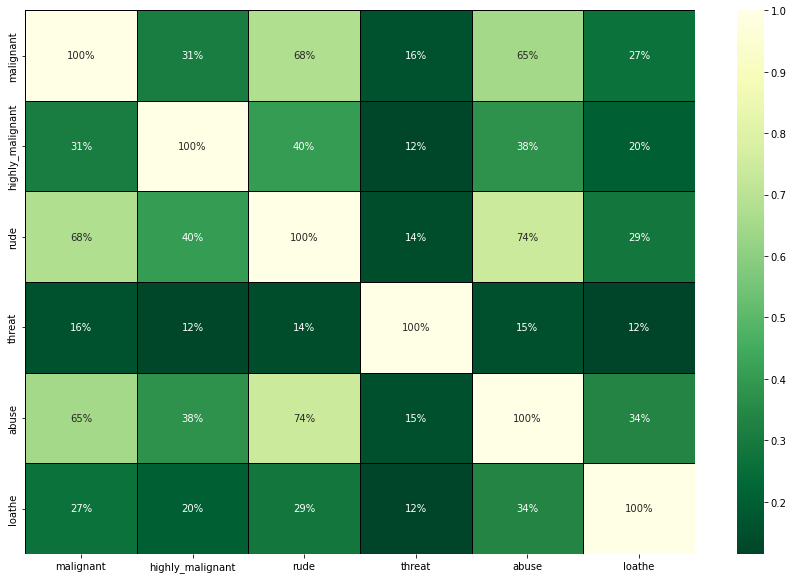

In [65]:
# Plotting heatmap for visualizing the correlation

plt.figure(figsize=(15, 10))
corr = df_train.corr() # corr() function provides the correlation value of each column
sns.heatmap(corr, linewidth=0.5, linecolor='black', fmt='.0%', cmap='YlGn_r', annot=True)
plt.show()

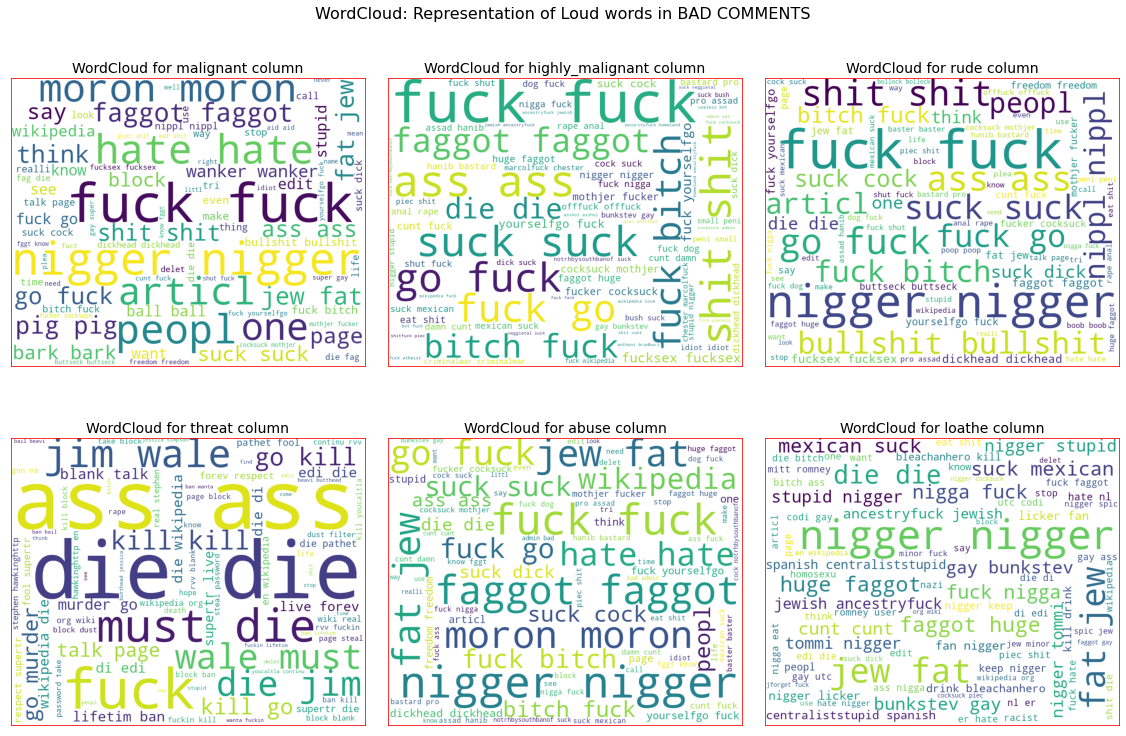

In [70]:
from wordcloud import WordCloud 

# WordCloud: Getting sense of loud words in each of the output labels.

cols = 3
rows = len(output_labels)//cols
if len(output_labels) % cols != 0:
    rows += 1
    
fig = plt.figure(figsize=(16,rows*cols*1.8))
fig.subplots_adjust(top=0.8, hspace=0.3)

p=1
for i in output_labels:
    word_cloud = WordCloud(height=650, width=800,
                           background_color="white",max_words=80).generate(' '.join(df.comment_text[df[i]==1]))
    ax = fig.add_subplot(rows,cols,p)
    ax.imshow(word_cloud)
    ax.set_title(f"WordCloud for {i} column",fontsize=14)
    for spine in ax.spines.values():
        spine.set_edgecolor('r')
       
    ax.set_xticks([])
    ax.set_yticks([])
    p += 1

fig.suptitle("WordCloud: Representation of Loud words in BAD COMMENTS",fontsize=16)
fig.tight_layout(pad=2)
plt.show()

# Data Preparation for Model Training and Testing


In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
# 1. Convert text to Vectors

# Converting text to vectors using TfidfVectorizer
tfidf = TfidfVectorizer(max_features=4000)
features = tfidf.fit_transform(df.comment_text).toarray()

# Checking the shape of features
features.shape

(159571, 4000)

In [76]:

from scipy.sparse import csr_matrix
# 2. Seperating Input and Output Variables

# input variables
X = features

# output variables
Y = csr_matrix(df[output_labels]).toarray()

# checking shapes of input and output variables to take care of data imbalance issue
print("Input Variable Shape:", X.shape)
print("Output Variable Shape:", Y.shape)

Input Variable Shape: (159571, 4000)
Output Variable Shape: (159571, 6)


# Classification Machine Learning Model building


In [77]:
# 3. Training and Testing Model on our train dataset

# Creating a function to train and test model
def build_models(models,x,y,test_size=0.33,random_state=42):
    # spliting train test data using train_test_split
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_size,random_state=random_state)
    
    # training models using BinaryRelevance of problem transform
    for i in tqdm.tqdm(models,desc="Building Models"):
        start_time = timeit.default_timer()
        
        sys.stdout.write("\n=======================================================================================\n")
        sys.stdout.write(f"Current Model in Progress: {i} ")
        sys.stdout.write("\n=======================================================================================\n")
        
        br_clf = BinaryRelevance(classifier=models[i]["name"],require_dense=[True,True])
        print("Training: ",br_clf)
        br_clf.fit(x_train,y_train)
        
        print("Testing: ")
        predict_y = br_clf.predict(x_test)
        
        ham_loss = hamming_loss(y_test,predict_y)
        sys.stdout.write(f"\n\tHamming Loss  : {ham_loss}")
                
        ac_score = accuracy_score(y_test,predict_y)
        sys.stdout.write(f"\n\tAccuracy Score: {ac_score}")
        
        cl_report = classification_report(y_test,predict_y)
        sys.stdout.write(f"\n{cl_report}")
        
        end_time = timeit.default_timer()
        sys.stdout.write(f"Completed in [{end_time-start_time} sec.]")
        
        models[i]["trained"] = br_clf
        models[i]["hamming_loss"] = ham_loss
        models[i]["accuracy_score"] = ac_score
        models[i]["classification_report"] = cl_report
        models[i]["predict_y"] = predict_y
        models[i]["time_taken"] = end_time - start_time
                      
        sys.stdout.write("\n=======================================================================================\n")
    
    models["x_train"] = x_train
    models["y_train"] = y_train
    models["x_test"] = x_test
    models["y_test"] = y_test
    
    return models

In [102]:
import timeit, sys
from sklearn import metrics
import tqdm.notebook as tqdm
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import hamming_loss, log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, multilabel_confusion_matrix

In [103]:



# Preparing the list of models for classification purpose
models = {"GaussianNB": {"name": GaussianNB()},
          "MultinomialNB": {"name": MultinomialNB()},
          "Logistic Regression": {"name": LogisticRegression()},
          "Random Forest Classifier": {"name": RandomForestClassifier()},
          "Support Vector Classifier": {"name": LinearSVC(max_iter = 3000)},
          "Ada Boost Classifier": {"name": AdaBoostClassifier()},
          "K Nearest Neighbors Classifier": {"name": KNeighborsClassifier()},
          "Decision Tree Classifier": {"name": DecisionTreeClassifier()},
          "Bagging Classifier": {"name": BaggingClassifier(base_estimator=LinearSVC())},
         }

# Taking one forth of the total data for training and testing purpose
half = len(df)//4
trained_models = build_models(models,X[:half,:],Y[:half,:])

Building Models:   0%|          | 0/9 [00:00<?, ?it/s]


Current Model in Progress: GaussianNB 
Training:  BinaryRelevance(classifier=GaussianNB(), require_dense=[True, True])
Testing: 

	Hamming Loss  : 0.21560957083175086
	Accuracy Score: 0.4729965818458033
              precision    recall  f1-score   support

           0       0.16      0.79      0.26      1281
           1       0.08      0.46      0.13       150
           2       0.11      0.71      0.19       724
           3       0.02      0.25      0.03        44
           4       0.10      0.65      0.17       650
           5       0.04      0.46      0.07       109

   micro avg       0.11      0.70      0.20      2958
   macro avg       0.08      0.55      0.14      2958
weighted avg       0.12      0.70      0.21      2958
 samples avg       0.05      0.07      0.05      2958
Completed in [17.918154500002856 sec.]

Current Model in Progress: MultinomialNB 
Training:  BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])
Testing: 

	Hamming Loss  : 0.02409

Testing: 

	Hamming Loss  : 0.020091150778579567
	Accuracy Score: 0.9137105962780099
              precision    recall  f1-score   support

           0       0.86      0.64      0.74      1281
           1       0.56      0.22      0.32       150
           2       0.90      0.65      0.76       724
           3       0.56      0.11      0.19        44
           4       0.74      0.54      0.62       650
           5       0.80      0.26      0.39       109

   micro avg       0.83      0.58      0.68      2958
   macro avg       0.74      0.40      0.50      2958
weighted avg       0.82      0.58      0.67      2958
 samples avg       0.06      0.05      0.05      2958
Completed in [168.70380460000888 sec.]


# Hyperparameter Tuning


In [105]:
# Choosing Linear Support Vector Classifier model

fmod_param = {'estimator__penalty' : ['l1', 'l2'],
              'estimator__loss' : ['hinge', 'squared_hinge'],
              'estimator__multi_class' : ['ovr', 'crammer_singer'],
              'estimator__random_state' : [42, 72, 111]
             }
SVC = OneVsRestClassifier(LinearSVC())
GSCV = GridSearchCV(SVC, fmod_param, cv=3)
x_train,x_test,y_train,y_test = train_test_split(X[:half,:], Y[:half,:], test_size=0.30, random_state=42)
GSCV.fit(x_train,y_train)
GSCV.best_params_

{'estimator__loss': 'hinge',
 'estimator__multi_class': 'ovr',
 'estimator__penalty': 'l2',
 'estimator__random_state': 42}

In [106]:
Final_Model = OneVsRestClassifier(LinearSVC(loss='hinge', multi_class='ovr', penalty='l2', random_state=42))
Classifier = Final_Model.fit(x_train, y_train)
fmod_pred = Final_Model.predict(x_test)
fmod_acc = (accuracy_score(y_test, fmod_pred))*100
print("Accuracy score for the Best Model is:", fmod_acc)
h_loss = hamming_loss(y_test,fmod_pred)*100
print("Hamming loss for the Best Model is:", h_loss)

Accuracy score for the Best Model is: 91.51069518716578
Hamming loss for the Best Model is: 1.9593917112299464


# AUC ROC Curve for Final Model


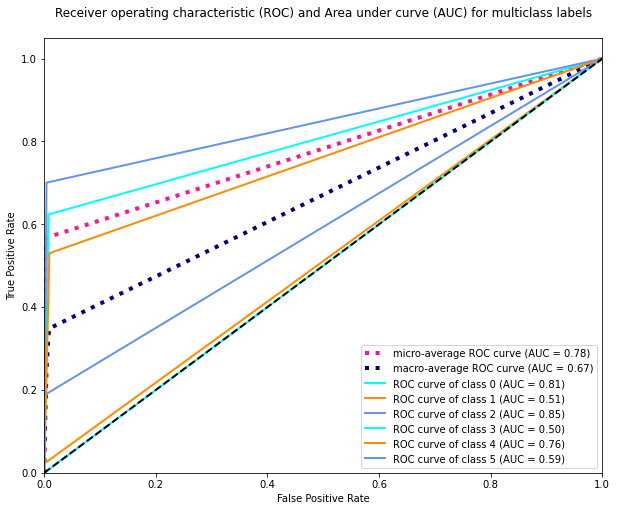

In [107]:
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], fmod_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), fmod_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.rcParams["figure.figsize"] = (10,8) # used to change the output figure size

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC) and Area under curve (AUC) for multiclass labels\n")
plt.legend(loc="lower right")
plt.show() 

I have generated the ROC Curve for my final model and it shows separate curve for every class present in our multi label target variable along with it's AUC values.



# Confusion Matrix for Final Model


In [108]:
print("Confusion matrix:\n\n", multilabel_confusion_matrix(y_test, fmod_pred))

Confusion matrix:

 [[[10710    83]
  [  442   733]]

 [[11832     1]
  [  132     3]]

 [[11263    47]
  [  197   461]]

 [[11930     0]
  [   38     0]]

 [[11266   106]
  [  280   316]]

 [[11869     3]
  [   78    18]]]


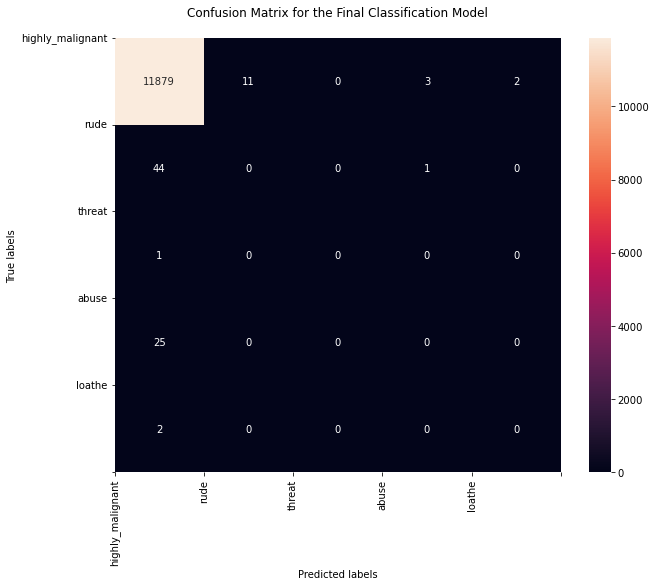

In [109]:
plt.rcParams["figure.figsize"] = (10,8) # used to change the output figure size
ax= plt.subplot()
cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(fmod_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  # annot=True to annotate cells, ftm='g' to disable scientific notation

# title, labels and ticks
ax.set_title('Confusion Matrix for the Final Classification Model\n'); 
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); 
loc = plticker.MultipleLocator()
ax.xaxis.set_major_locator(loc); ax.yaxis.set_major_locator(loc);
ax.set_xticklabels(comments_labels); ax.set_yticklabels(comments_labels);
plt.xticks(rotation=90); plt.yticks(rotation=0);
plt.show()

With the help of above confusion matrix I am able to understand the number of times I got the correct outputs and the number of times my final model missed to provide the correct prediction (depicting in the black boxes).



# Model Saving or Serialization


In [110]:
# selecting the best model
best_model = trained_models['Support Vector Classifier']['trained']

# saving the best classification model
joblib.dump(best_model,open('Malignant_comments_classifier.pkl','wb'))

# Preprocessing Pipeline for test dataframe


The following preprocessing pipeline is required to perform model prediction:



In [111]:
# Remove null values
if df_test.isnull().sum()[1] != 0:
    df_test.dropna(inplace=True)
    
# Drop coulmn id
df_test.drop(columns=['id'],inplace=True)

# Convert comment text to lower case and replace '\n' with single space
df_test["comment_text"] = df_test.comment_text.str.lower()
df_test["comment_text"] = df_test.comment_text.str.replace('\n',' ')

# Keep only text data i.e., a-z' and remove other data from comment text.
df_test.comment_text = df_test.comment_text.apply(lambda x: ' '.join(regexp_tokenize(x,"[a-z']+")))

# Remove stopwords
df_test.comment_text = df_test.comment_text.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words).strip())

# Remove punctuations
df_test.comment_text = df_test.comment_text.str.replace("[^\w\d\s]","")

# Apply Stemming using SnowballStemmer
df_test.comment_text = df_test.comment_text.apply(lambda x: ' '.join(snb_stem.stem(word) for word in word_tokenize(x)))

print(df_test.info(memory_usage="deep"))

# Convert text to vectors using TfidfVectorizer
tfidf = TfidfVectorizer(analyzer = 'word', max_features=4000)
test_features = tfidf.fit_transform(df_test.comment_text).toarray()
# Load saved or serialized model and predict
model_loaded = joblib.load('Malignant_comments_classifier.pkl')

# Make predictions and view the results
predict_test = model_loaded.predict(test_features)

# Saving predicted values into a CSV file
pd.DataFrame(predict_test.toarray()).to_csv('Predicted_test_output.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  153164 non-null  object
dtypes: object(1)
memory usage: 37.2 MB
None


In [112]:
df1 = pd.read_csv('Predicted_test_output.csv')
df1.drop("Unnamed: 0", axis=1, inplace=True)
df1.rename({'0':'malignant', '1':'highly_malignant', '2':'rude', '3':'threat', '4':'abuse', '5':'loathe'}, 
           axis='columns', inplace=True)
df2=df_test.copy()
df = pd.concat([df2, df1], axis=1)
df 

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,yo bitch ja rule succes ever what hate sad mof...,0,0,0,0,0,0
1,rfc titl fine imo,0,0,0,0,0,0
2,sourc zaw ashton lapland,0,0,0,0,0,0
3,look back sourc inform updat correct form gues...,0,0,0,0,0,0
4,anonym edit articl,0,0,0,0,0,0
...,...,...,...,...,...,...,...
153159,total agre stuff noth long crap,0,0,0,0,0,0
153160,throw field home plate get faster throw cut ma...,0,0,0,0,0,0
153161,okinotorishima categori see chang agre correct...,0,0,0,0,0,0
153162,one found nation eu germani law return quit si...,0,0,0,0,0,0


In [113]:
df.to_csv('Malignant_Comments_Classifier_test_dataset_predictions.csv', index=False)

# Inference

Starting with univariate analysis, with the help of count plot it was found that dataset is imbalanced with having higher number of records for normal comments than bad comments (including malignant, highly malignant, rude, threat, abuse and loathe). Also, with the help of distribution plot for comments length it was found that after cleaning most of comments length decreases from range 0-1100 to 0-900. Moving further with wordcloud it was found that malignant comments consists of words like fuck, nigger, moron, hate, suck etc. highly_malignant comments consists of words like ass, fuck, bitch, shit, die, suck, faggot etc. rude comments consists of words like nigger, ass, fuck, suck, bullshit, bitch etc. threat comments consists of words like die, must die, kill, murder etc. abuse comments consists of words like moron, nigger, fat, jew, bitch etc. and loathe comments consists of words like nigga, stupid, nigger, die, gay, cunt etc.

# Problems faced while working in this project:


More computational power was required as it took more time for processing the huge dataset.
Imbalanced dataset and bad comment texts.
Better parameters could not be obtained using hyperparameter tuning as more time was consumed.

# Areas of improvement:


Less time complexity
Providing a proper balanced dataset with less errors.